In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import matplotlib.pylab as pylab
import matplotlib as mpl
# functions to get LP from cosmology
import linear_point as lp
# doing cosmological calculations from parameters
import camb

%matplotlib inline

In [29]:
# for plots
sns.set_style("ticks",
             rc = {'axes.grid' : False,
                  'grid.linestyle' : 'dashed',
                  "xtick.direction": "in","ytick.direction": "in"})

sns.set_context('paper', font_scale=1.7)
pylab.rcParams['xtick.major.pad']='6'
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

sns.set_palette("Set1")

In [3]:
# creanting instance of CAMBparams object
pars = camb.CAMBparams()
# krange
kmin = 0.001
kmax = 10.

In [4]:
# fiducial TT,TE,EE + lowP
ombh2_fid=0.02225
omch2_fid=0.1198
h_fid = 0.6790
tau_fid = 0.079
ns_fid=0.9645
As_fid=2.207e-9
# sigmas
ombh2_sig = 0.00016
omch2_sig = 0.0015
ns_sig = 0.0049

In [5]:
def get_results(pars, z=0, ombh2 = ombh2_fid, omch2 = omch2_fid,
                h = h_fid, tau = tau_fid, As = As_fid, ns = ns_fid):
    pars.set_cosmology(ombh2=ombh2,
                       omch2 =omch2,
                       H0=100*h,
                       tau=tau)
    pars.InitPower.set_params(ns=ns,
                              As=As)
    pars.set_matter_power(
        redshifts=[z], kmax=kmax, nonlinear=False, k_per_logint=0)
    return camb.get_results(pars)

def get_lp(results, kmin=kmin, kmax=kmax):
    dip, peak = lp.lp_from_cosmo_mpc(results, kmin, kmax)
    return (dip+peak)/2

def get_rd(results):
    return results.get_derived_params()['rdrag']

def get_lp_rd_ratio(results):
    lp = get_lp(results)
    rd = get_rd(results)
    return lp/rd

In [6]:
# fiducial
results = get_results(pars)
lp_fid = get_lp(results)
rd_fid = get_rd(results)
print("lp_fid:{:.2f} , rd_fid:{:.2f}".format(lp_fid, rd_fid))

lp_fid:138.24 , rd_fid:147.28


In [7]:
# for parameter exploration
steps = 100
sigma_range = 10
# getting values
ombh2_vals = np.linspace(ombh2_fid - sigma_range*ombh2_sig,
                         ombh2_fid + sigma_range*ombh2_sig, steps)

omch2_vals = np.linspace(omch2_fid - sigma_range*omch2_sig,
                         omch2_fid + sigma_range*omch2_sig, steps)

ns_vals = np.linspace(ns_fid - sigma_range*ns_sig,
                         ns_fid + sigma_range*ns_sig, steps)

In [ ]:
# getting results
#ombh2
df_ombh2 = pd.DataFrame(columns=['ombh2','lp','rd'])

for i, ombh2 in enumerate(ombh2_vals):
    results = get_results(pars, ombh2 = ombh2)
    df_ombh2.loc[i] = [ombh2, get_lp(results), get_rd(results)]
    
print("Done with ombh2")
#ombh2
df_omch2 = pd.DataFrame(columns=['omch2','lp','rd'])

for i, omch2 in enumerate(omch2_vals):
    results = get_results(pars, omch2 = omch2)
    df_omch2.loc[i] = [omch2, get_lp(results), get_rd(results)]

print("Done with omch2")
#ombh2
df_ns = pd.DataFrame(columns=['ns','lp','rd'])

for i, ns in enumerate(ns_vals):
    results = get_results(pars, ns = ns)
    try:
        df_ns.loc[i] = [ns, get_lp(results), get_rd(results)]
    except:
        print("Broke when ns={}".format(ns))
        df_ns.loc[i] = np.nan
    
print("Done with ns")

In [9]:
df_ombh2.to_pickle('./output/lp_rd/df_ombh2.pkl')
df_omch2.to_pickle('./output/lp_rd/df_omch2.pkl')
df_ns.to_pickle('./output/lp_rd/df_ns.pkl')

##  plotting r/rfid

In [7]:
df_ombh2 = pd.read_pickle('./output/lp_rd/df_ombh2.pkl')
df_omch2 = pd.read_pickle('./output/lp_rd/df_omch2.pkl')
df_ns = pd.read_pickle('./output/lp_rd/df_ns.pkl')

dfs = [df_ombh2, df_omch2, df_ns]

# outlier and nan exclusion (the rootfinding is misfiring very rarely
# should look into that when there is time
z_threshold = 5 #how many sigmas to qualify as an outlier
for i, df in enumerate(dfs):
    z = np.abs(df - df.mean())/df.std() # get z for every entry
    print("Dropping") if (z > z_threshold).any().any() else print("Not Dropping")
    df = df.loc[~(z > z_threshold).any(axis=1)] #drops rows that have outliers
    df = df.dropna() #drop nans
    dfs[i] = df

Not Dropping
Dropping
Dropping


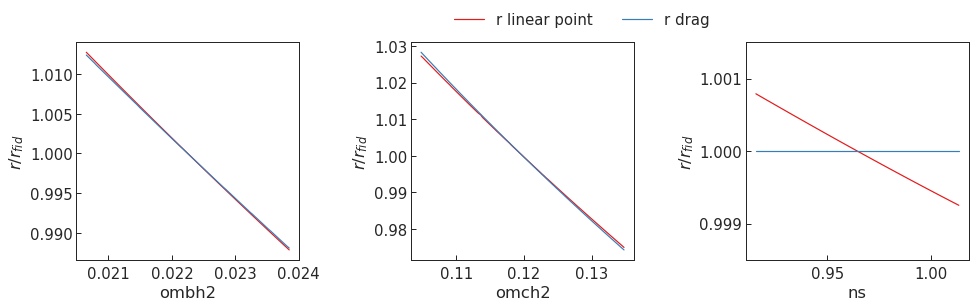

In [8]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(16,4), sharey=False)
axes = [ax1, ax2, ax3]

# plotting
for ax, df in zip(axes,dfs):
    ax.plot(df.iloc[:,0], df.loc[:,'lp']/lp_fid, label='r linear point')
    ax.plot(df.iloc[:,0], df.loc[:,'rd']/rd_fid, label='r drag')
    ax.set_xlabel(df.columns[0])
    ax.set_ylabel(r'$r/r_{fid}$')

# legend
ax1.legend(loc='best',ncol=2,frameon=False, bbox_to_anchor=(2.9, 1.2))

#
plt.subplots_adjust(wspace=0.5)

ax3.set_ylim(0.9985,1.0015)
ax3.set_yticks([0.999, 1.000, 1.001])


plt.savefig('./Figures/lp_rd/r_over_r_fid_lp_and_rdrag.pdf', dpi=200,
           bbox_inches='tight')
plt.show()

## plotting r_lp/r_drag

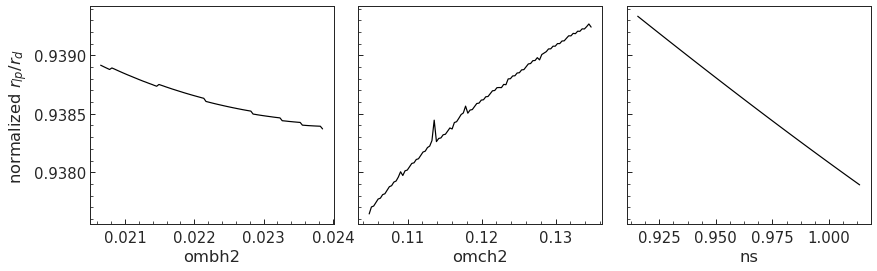

In [31]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(14,4), sharey=True)
axes = [ax1, ax2, ax3]
factor = rd_fid/lp_fid
factor = 1
# ax1
for ax, df in zip(axes,dfs):
    ax.plot(df.iloc[:,0], factor*df.loc[:,'lp']/df.loc[:,'rd'],'k')
    ax.set_xlabel(df.columns[0])

ax1.set_ylabel(r'normalized $r_{lp}/r_{d}$') # update label - normalized ratio now
#
plt.subplots_adjust(wspace=0.1)

# plt.savefig('./Figures/lp_rd/rlp_over_rdrag.pdf', dpi=200,
#            bbox_inches='tight')

plt.show()

In [10]:
# is the source of noise coming from lp or rd?

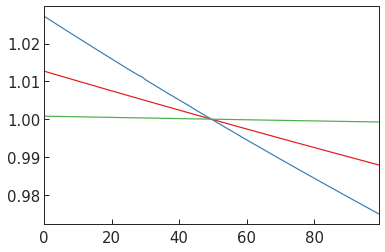

In [11]:
for df in dfs:
    (df['lp']/lp_fid).plot()

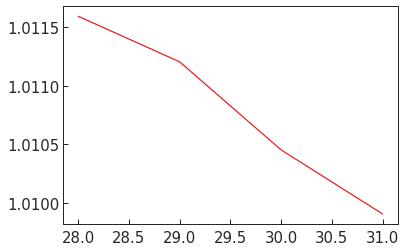

In [16]:
plt.plot(dfs[1]['lp'].iloc[28:32]/lp_fid)

In [22]:
from importlib import reload

In [24]:
reload(lp)

<module 'linear_point' from '/home/marcio/Dropbox/Doutorado/Research/Projects/Linear Point/linear_point.py'>